<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/MonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IMonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# CNNs to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordings

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

try:
    from google.colab import files
    %tensorflow_version 2.x  # Only on colab
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    # TODO: Clone MonkeyPFC repository and cd there
    
    !pip install -q kaggle
    plt.style.use('dark_background')
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    # Add IntracranialNeurophysDL repository to path.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'IntracranialNeurophysDL'
    sys.path.append(str(indl_path))
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
from indl import turbo_cmap
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

In [2]:
# Download and unzip data
if IN_COLAB:
    datadir = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    datadir = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (datadir).is_dir():
    !kaggle datasets download --unzip --path {str(datadir)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one session
TODO: Explain data.

### Load the data
Let's use a helper function from the repo to load the data.
You can see the code for `load_macaque_pfc` [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py).

We load the spikes for our deep models, but we'll also load the rates for the shallow models and some visualizations below.

In [3]:
from misc.misc import load_macaque_pfc

SESS_ID = 'sra3_1_j_050_00'
# SESS_ID = 'sra3_1_m_074_0001'
X, Y, ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spiketrains', zscore=False,
                                 valid_outcomes=(0,), dprime_range=(1.0, np.inf))
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 1027 trials, 1650 timestamps (-0.2 to 1.449 at 1000.0 Hz), 32 channels


In [4]:
# Load spike rates for LDA and visualizations.
rates_X, rates_Y, rates_ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True,
                                                   valid_outcomes=(0,), dprime_range=(1.0, np.inf))
print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    len(rates_ax_info['instance_data']), len(rates_ax_info['timestamps']),
    rates_ax_info['timestamps'][0], rates_ax_info['timestamps'][-1], rates_ax_info['fs'], rates_X.shape[-1]))

Found 1027 trials, 166 timestamps (-0.2 to 1.45 at 100.0 Hz), 32 channels


### Get baseline accuracy

Next we will use "shallow" machine learning techniques to train a model to predict intended saccade direction.

#### LDA
A good first approach would be to use multi-class LDA. Given the number of features (timestamps * channels), LDA is likely to over-fit. We can use regularization. However, sk-learn's LDA regularization relies on the `'eigen'` solver which can run out of memory when operating on very large feature matrices. You can try the cell below, but it may not work depending on how many channels and timestamps we have. sk-learn probably has other mechanisms to regularize LDA, but we'll instead use a different ML algorithm in a couple cells below.

In [5]:
# Depending on data shape you may run out of memory here.
# Either way, you can achieve the same result using a different method in the next code cell.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10, shuffle=True)

y_preds = []
y_true = []
fold_ix = 0
for trn, tst in splitter.split(rates_X, rates_Y):
    fold_ix += 1
    print("Fold {}".format(fold_ix))
    lda.fit(rates_X[trn].reshape(-1, np.prod(rates_X.shape[1:])), rates_Y[trn].ravel())
    y_preds.append(lda.predict(rates_X[tst].reshape(-1, np.prod(rates_X.shape[1:]))))
    y_true.append(rates_Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 84.79138627187079


#### Logistic Regression
Instead of LDA, we'll use Logistic Regression. sk-learn's regularization scheme for logistic regression is more robust than for LDA. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's actually a classification algorithm.

We start by using all available time points to try to get the best accuracy.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 500
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(rates_X, rates_Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(rates_X[trn].reshape(-1, np.prod(rates_X.shape[1:])), rates_Y[trn].ravel())
    y_preds.append(model.predict(rates_X[tst].reshape(-1, np.prod(rates_X.shape[1:]))))
    y_true.append(rates_Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 84.65679676985195


The accuracy using shallow methods is around 60% for monkey M and 81-83% for monkey J. Is this good?

There are 8 different classes in the data. Chance accuracy _should_ be 12.5%. However, condition-pairs were presented in blocks, so a classifier that could simply identify "block" (e.g. by heavily weighting transient neurons) would achieve ~50% accuracy. The best way to know is to run the classifier again using only data available before any stimulus was presented, and again using only data after the stimulus was presented but before the cue indicated the correct stimulus was presented.

Next we run the classification using only the data from before the targets were presented.

In [7]:
args['max_iter'] = 1000
model = LogisticRegression(**args)
b_times = rates_ax_info['timestamps'] < 0
_X = rates_X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, rates_Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), rates_Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(rates_Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-trial data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-trial data only: 30.219256434699712%


Then we run it again using only the data before the cues appeared, including the 0.25 s after the targets appeared.
At this point, the monkey knows the two potential target locations. He/she will know which is the cue and which is the target only after cue onset.

In [8]:
b_times = rates_ax_info['timestamps'] < 0.250
_X = rates_X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, rates_Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), rates_Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(rates_Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-cue data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-cue data only: 43.374642516682556%


Without any stimulus information at all, decoder accuracy was 29-34%. Including neural data after the target-distractor pair appeared, but before the cue appeared (i.e. before the monkey had enough information to know the correct target), decoder accuracy was 42-47%. Our decoder using all of the data up to the imperative cue had an accuracy of 60% in one dataset and 81% in another, which is much higher than these 'baseline' values. These results suggest that the model learned something about the relationship between neural activity and intended saccade direction.

### Prepare data for deep learning

In [21]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Custom Features

1. Convolution kernel regularization to keep non-zero segment as short as possible in the middle. Multiply abs kernel values by 1-window_func centered on kernel midpoint. (idea: multiple abs(w) > 0 by distance... don't care about magnitude, just whether or not they are non-zero)
    * [reference](https://www.tensorflow.org/guide/keras/custom_layers_and_models#layers_recursively_collect_losses_created_during_the_forward_pass)
    
2. Concatenate AvgPooling and MaxPooling outputs.

In [5]:
# A Conv2D layer that penalizes long kernel lengths.
class Conv2DWindowedKernel(tf.keras.layers.Conv2D):
    def __init__(self, filters, kernel_size, window_scale=1e-2, window_func='hann', **kwargs):
        super(Conv2DWindowedKernel, self).__init__(filters, kernel_size, **kwargs)
        self.window_scale = window_scale
        self.window_func = window_func
        # TODO: Make a 2-D window.
        if self.window_func == 'hann':
            self.window = 1 - tf.signal.hann_window(self.kernel_size[0], periodic=False)
        elif self.window_func == 'hamming':
            self.window = 1 - tf.signal.hamming_window(self.kernel_size[0], periodic=False)
        else:  # if window_func == 'linear':
            hl = self.kernel_size[0]//2
            self.window = np.zeros((self.kernel_size[0],), dtype=np.float32)
            self.window[:hl] = np.arange(1, hl+1)[::-1]
            self.window[-hl:] = np.arange(1, hl+1)
            self.window = self.window / hl
            if self.window_func == 'quadratic':
                self.window = self.window**2
        self.window = tf.reshape(self.window, (self.kernel_size[0], 1, 1, 1))
        
    def call(self, inputs):
        outputs = super(Conv2DWindowedKernel, self).call(inputs)
        non_zero = tf.cast(tf.abs(self.kernel) > 0, tf.float32)
        loss = self.window * non_zero
        loss = tf.reduce_max(loss, axis=0)
        loss = tf.reduce_mean(loss)
        self.add_loss(self.window_scale * loss)
        return outputs
    
    def get_config(self):
        config = super(Conv2DWindowedKernel, self).get_config()
        config.update({'window_scale': self.window_scale, 'window_func': self.window_func})
        return config
    
test_layer = Conv2DWindowedKernel(3, (22, 1), padding='same', window_func='quadratic')
test_layer(tf.ones((1, 22, 1, 1)))
print(test_layer.losses)

[<tf.Tensor: id=48, shape=(), dtype=float32, numpy=0.01>]


## Create our model

Our model objective is to transform timeseries segments into probabilities of each class. We are also going to use an auto-encoder to try to force our segments into a low-dimensional representation. To complicate matters, the encoder is not going to reconstruct the input spikes, but a convolved version of the input spikes, which we call 'rates', that exist only in within the model. And, if we get all that working, another complication is that the weighting of the loss between the class prediction and autoencoder reconstruction is going to change after each step to try to make them have roughly equal contribution to the loss.

Let's start with a function to make the model...

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm


def make_model(T, C, aug_offset=50,
               window_scale=0,
               k_spike_short=10, l_spike_short=22,
               k_spike_long=4, l_spike_long=200,
               D=4,
               activation='relu',
               downsamp_1=5,
               n_pointwise_filters=38, kern_length_2=40, downsamp_2=8,
               latent_dim=10, autoenc=True,
               norm_rate=0.4, dropout_rate=0.4, l1_reg=0.0002, l2_reg=0.0002):
    """
    def make_model(T, C, aug_offset=50,
               k_spike_short=10, l_spike_short=22,
               k_spike_long=4, l_spike_long=200,
               D=4,
               activation='relu',
               downsamp_1=5,
               n_pointwise_filters=38, kern_length_2=40, downsamp_2=8,
               latent_dim=10, gamma=0.0,
               norm_rate=0.3, dropout_rate=0.3, l1_reg=0.0001, l2_reg=0.0001)
               
    Best Parameters: {'D': 6.0, 'downsamp_1': 5.0, 'downsamp_2': 7.0, 'k_spike_long': 1.0,
    'k_spike_short': 9.0, 'kern_length_2': 40.0, 'l_spike_long': 95.0, 'l_spike_short': 22.0,
    'n_pointwise_filters': 38.0}
    
    'gamma': 6.779524845140285, 'k_spike_long': 9.0,
    'latent_dim': 45.0, 'window_scale': 0.002594990540345511
    """
    n_timesteps = T - aug_offset
    _input = tf.keras.Input(shape=(n_timesteps, C, 1))
    
    # Spike kernel convolutions. Parallel branches for short and long.
    # TODO: I would like to someday have a CNN layer with a regularization factor
    # for the kernel length, i.e. lengthen head and tail zeros possible.
    # What about regularization for smoothness, i.e. penalize sum(diff(sign(diff(weights))))?
    # Be sure to compare this to SINCNet
    if window_scale:
        _rates = Conv2DWindowedKernel(k_spike_short + k_spike_long, (l_spike_long, 1),
                                  padding='same',
                                  use_bias=False,
                                  window_func='linear',
                                  window_scale=window_scale)(_input)
    else:    
        _y_short = layers.Conv2D(k_spike_short, (l_spike_short, 1),
                                 padding='same',
                                 use_bias=False,
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                )(_input)  # Spike kernel short
        _y_long = layers.Conv2D(k_spike_long, (l_spike_long, 1),
                                padding='same',
                                use_bias=False,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                               )(_input)    # Spike kernel long
        _rates = layers.Concatenate(axis=-1, name='rates')([_y_short, _y_long])
    
    # _y = layers.Activation(activation)(_y) # new
    # _y = layers.BatchNormalization(axis=1)(_y) # new
    # _y = layers.AveragePooling2D((3, 1))(_y)  # new Decimation
    # _y = layers.Dropout(dropout_rate)(_y) # new
    
    # Spatial filter.
    _y = layers.DepthwiseConv2D((1, C),
                                use_bias=False,
                                depth_multiplier=D,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                depthwise_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                depthwise_constraint=max_norm(1.),
                                name='spatial_filter')(_rates)
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=-1)(_y)
    _y = layers.AveragePooling2D((downsamp_1, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    
    # Feature aggregation
    _y = layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='same',
                                use_bias=False,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                pointwise_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                name='feature_aggreg_conv'
                               )(_y)
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=-1)(_y)
    _y = layers.AveragePooling2D((downsamp_2, 1), name='feature_aggreg_downsamp')(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    
    # To latent dim bottleneck
    _y = layers.Flatten()(_y)
    _y = layers.Dense(latent_dim, activation=tf.nn.relu)(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    _bottleneck = layers.Activation(activation, name='latent')(_y)
    
    # To class predictions
    _y = layers.Dense(8, kernel_constraint=max_norm(norm_rate))(_bottleneck)
    _class_preds = layers.Activation('softmax', name='class_preds')(_y)
    
    if autoenc:
        # From bottleneck back to reconstructed rates
        n_unpack = n_timesteps // downsamp_1 // downsamp_2
        _x = layers.Dense(n_pointwise_filters * n_unpack, name='unpack')(_bottleneck)
        _x = layers.Activation(activation)(_x)
        _x = layers.BatchNormalization(axis=-1)(_x)
        _x = layers.Dropout(dropout_rate)(_x)
        _x = layers.Reshape(target_shape=(n_timesteps // downsamp_1 // downsamp_2, 1,
                                          n_pointwise_filters))(_x)
        
        _x = layers.Conv2DTranspose(D * (k_spike_short + k_spike_long),
                                    (kern_length_2, 1),
                                    strides=(downsamp_2, 1),
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                    padding='same')(_x)
        _x = layers.Activation(activation)(_x)
        _x = layers.BatchNormalization(axis=-1)(_x)
        _x = layers.Dropout(dropout_rate)(_x)
        
        _x = layers.Conv2DTranspose(k_spike_short + k_spike_long,
                                    (1, C),
                                    strides=(downsamp_1, C),
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                    padding='same')(_x)
        _x = layers.BatchNormalization(axis=-1)(_x)
#         _x = layers.Dropout(dropout_rate)(_x)
        _recon_rates = layers.Activation('tanh')(_x)
        
        model = tf.keras.Model(inputs=_input, outputs=[_class_preds, _rates, _recon_rates])
        
    else:
        model = tf.keras.Model(inputs=_input, outputs=_class_preds)
    
    return model

tf.keras.backend.clear_session()
model = make_model(X.shape[1], X.shape[2])
model.summary()

22011
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600, 32, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1600, 32, 10) 220         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1600, 32, 4)  800         input_1[0][0]                    
__________________________________________________________________________________________________
rates (Concatenate)             (None, 1600, 32, 14) 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

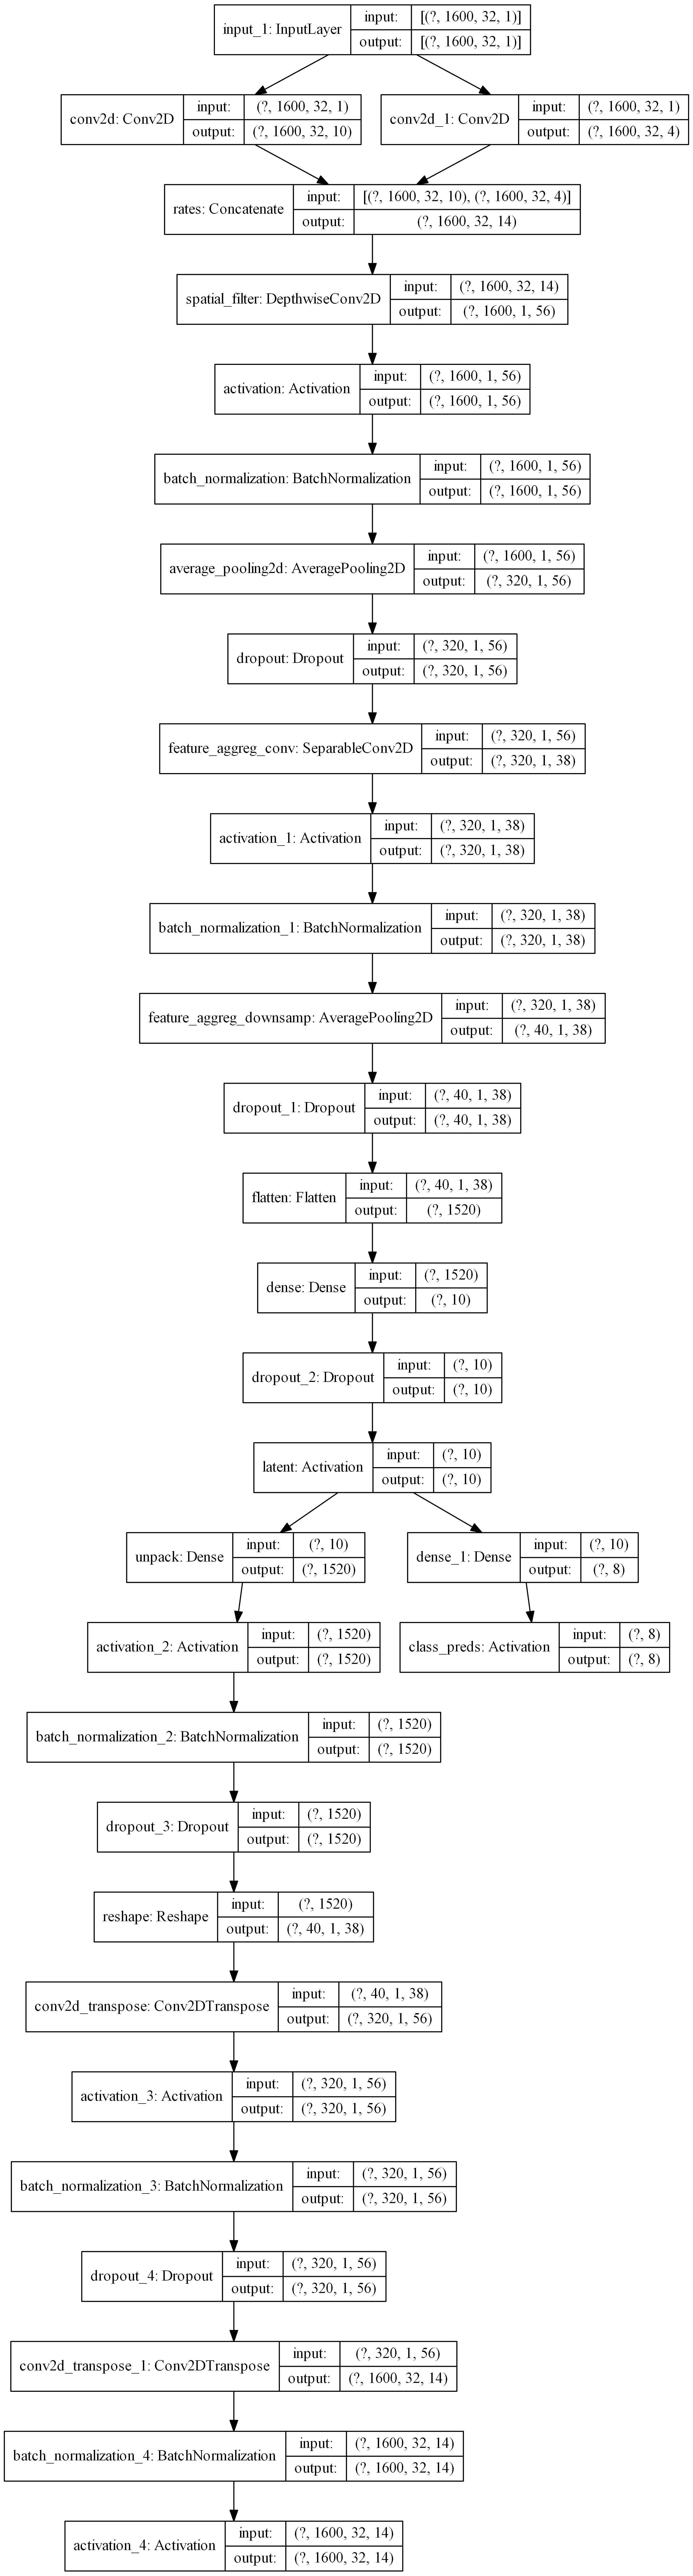

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', to_file='model.png', dpi=300)

### Keras API Shortcomings

Using the regular Keras API for model compilation and training will not work for us. One shortcoming of the easy API is that, when using `model.fit()`, each model output will be passed to its loss function independently. However, we need our outputs together (i.e., to calculate error from rates - reconstructed_rates).

One thing we COULD do is have the model use a Subtract layer to calculate the (rates - reconstructed_rates) error, then we could output error and calculate the mean square using a custom loss function. We'd thus need separate loss functions for each output and a way to weight them. We have an example of what that might look like below, though we aren't going to use it.

In [ ]:
if False:
    def mean_square(y_true, model_out):
        return tf.reduce_mean(tf.square(model_out))

    static_losses = {
        'recon_err': mean_square,
        'class_preds': 'sparse_categorical_crossentropy'
    }
    
    loss_weights = {
        'recon_err': 0.5,
        'class_preds': 0.5
    }

    # Now we can compile the model as follows:
    model.compile(loss=static_losses, loss_weights=loss_weights, optimizer='Nadam')

For this to work, we would also have to provide 2 different y inputs (this surprised me and I think I might be wrong, but that's how I interpreted the error). That's possible, but maybe not worth it, especially considering the next problem.

### Dynamic Gamma

Using the standard Keras API and the above model, we cannot modify the weighting across losses after each iteration. I spent some time looking at variational autoencoders to see how we might be able to implement dynamic loss weighting in tf2/keras. The examples I found are below.

* In the [TensorFlow CVAE autoencoder tutorial](https://www.tensorflow.org/tutorials/generative/cvae#wire_up_the_generative_and_inference_network_with_tfkerassequential), they use OOP to define a custom model class, and they also do manual training and loss calculation.
* In the TensorFlow Keras guide for making custom model classes, [where they make a variational autoencoder](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example), they also use OOP to define the custom model class (point of the guide) and use manual training and loss calculation.
* In a [blog post about custom loss functions example variational auto-encoder](https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618), the KL-weighting of losses changes using a custom callback. The scheduler definition [is here](https://github.com/eyalzk/sketch_rnn_keras/blob/master/utils.py#L180-L208) and its instantiation [is here](https://github.com/eyalzk/sketch_rnn_keras/blob/master/seq2seqVAE_train.py#L37-L40).

Following the last example, we could have 2 loss functions as our test above; the class-prediction would remain the same, but the loss function would be wrapped in a function closure (see blog post) where the outer function received the model as an input, and from the model retrieved the value of gamma. Note that the model's storage of gamma would have to use a tf.Variable or placeholder. Then, callbacks would be used to update the model's stored gamma. This seems like a lot of work to avoid using a manual training loop.

TODO: [Read this](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/) blog post on concise VAE, but I don't think it has dynamic KL-weighting.

## Train the model
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [23]:
N_SPLITS = 10
BATCH_SIZE = 10
MAX_OFFSET = 50
N_EPOCHS = 80
LEARN_RATE = 0.0025

#### Forward-Step

Define the forward step through the model. Manual training with GradientTape
[Reference](https://www.tensorflow.org/guide/keras/train_and_evaluate#part_ii_writing_your_own_training_evaluation_loops_from_scratch).

TODO: Need a [learning rate schedule](https://www.tensorflow.org/guide/keras/train_and_evaluate#using_learning_rate_schedules).

In [24]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=123)
split_ix = 0
hists = []

for trn, tst in splitter.split(X, Y):
    print("Running split {} of {}".format(split_ix + 1, N_SPLITS))
    
    tf.keras.backend.clear_session()
    
    # Get the training/testing data for this split.
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    # Create new model
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET)
    
    # Create loss functions for different outputs.
    class_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    recon_loss_fn = tf.keras.losses.MeanSquaredError()
    
    # Create metrics for monitoring training progress.
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    train_err_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    val_err_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    train_ae_metric = tf.keras.metrics.MeanSquaredError()
    val_ae_metric = tf.keras.metrics.MeanSquaredError()
    
    optimizer = tf.keras.optimizers.Nadam(lr=LEARN_RATE)

    gamma = 1.0
    
    @tf.function
    def my_train_step(train_x, train_y, gamma):
        with tf.GradientTape() as tape:
            logits, rates, recon_rates = model(train_x)
            class_loss = class_loss_fn(train_y, logits)
            recon_loss = recon_loss_fn(rates, recon_rates)
            total_loss = gamma * recon_loss + class_loss
            # total_loss = class_loss

        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        return logits, rates, recon_rates, class_loss, recon_loss, total_loss
    
    epoch_hist = {'accuracy': [], 'val_accuracy': [],
                  'loss': [], 'val_loss': [],
                  'ae_loss': [], 'val_ae_loss': [],
                  'gamma': []
                 }
    for epoch in range(N_EPOCHS):
        print('Running epoch {} of {}'.format(epoch + 1, N_EPOCHS))
        for step, (train_x, train_y) in enumerate(ds_train):
            logits, rates, recon_rates, class_loss, recon_loss, total_loss = my_train_step(train_x, train_y, gamma)
            gamma = class_loss / recon_loss
            
            train_acc_metric(train_y, logits)
            train_err_metric(train_y, logits)
            train_ae_metric(rates, recon_rates)
                
        # Run a validation loop at the end of each epoch.
        for valid_x, valid_y in ds_valid:
            v_logits, v_rates, v_recon_rates = model(valid_x)
            
            val_acc_metric(valid_y, v_logits)
            val_err_metric(valid_y, v_logits)
            val_ae_metric(v_rates, v_recon_rates)
            
        # Display metrics at the end of each epoch.
        train_acc = float(train_acc_metric.result())
        val_acc = float(val_acc_metric.result())
        train_err = float(train_err_metric.result())
        val_err = float(val_err_metric.result())
        train_ae = float(train_ae_metric.result())
        val_ae = float(val_ae_metric.result())
        
        print('acc: {:.2f} ({:.2f}),\tloss {:.2E} ({:.2E}), \tae_loss {:.2E} ({:.2E})'.format(
            100*train_acc, 100*val_acc, train_err, val_err, train_ae, val_ae
        ))
        
        if epoch == 0 or val_acc >= max(epoch_hist['val_accuracy']):
            fname = str(datadir / 'models' / (SESS_ID + '_model{}_best.h5'.format(split_ix)))
            tf.keras.models.save_model(model, fname)
        
        epoch_hist['accuracy'].append(train_acc)
        epoch_hist['val_accuracy'].append(val_acc)
        epoch_hist['loss'].append(train_err)
        epoch_hist['val_loss'].append(val_err)
        epoch_hist['ae_loss'].append(train_ae)
        epoch_hist['val_ae_loss'].append(val_ae)
        epoch_hist['gamma'].append(gamma)
        
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        train_err_metric.reset_states()
        val_err_metric.reset_states()
        train_ae_metric.reset_states()
        val_ae_metric.reset_states()
    
    hists.append(epoch_hist)
    split_ix += 1
    tf.keras.backend.clear_session()

34056
Running split 1 of 10
264
Running epoch 1 of 80
acc: 15.11 (16.50),	loss 2.07E+00 (2.06E+00), 	ae_loss 5.07E-04 (1.14E-03)
Running epoch 2 of 80
acc: 21.93 (33.98),	loss 1.88E+00 (1.32E+00), 	ae_loss 1.23E-03 (8.31E-04)
Running epoch 3 of 80
acc: 50.91 (56.31),	loss 1.15E+00 (1.15E+00), 	ae_loss 4.88E-04 (1.79E-04)
Running epoch 4 of 80
acc: 57.39 (70.87),	loss 1.11E+00 (5.79E-01), 	ae_loss 3.81E-04 (7.87E-04)
Running epoch 5 of 80
acc: 70.11 (70.87),	loss 5.82E-01 (5.19E-01), 	ae_loss 5.95E-04 (4.11E-04)
Running epoch 6 of 80
acc: 70.57 (67.96),	loss 5.38E-01 (5.74E-01), 	ae_loss 2.44E-04 (7.64E-05)
Running epoch 7 of 80
acc: 64.55 (69.90),	loss 8.13E-01 (5.51E-01), 	ae_loss 5.11E-05 (1.99E-05)
Running epoch 8 of 80
acc: 61.82 (72.82),	loss 8.82E-01 (4.97E-01), 	ae_loss 3.02E-04 (5.35E-04)
Running epoch 9 of 80
acc: 73.75 (72.82),	loss 5.30E-01 (4.80E-01), 	ae_loss 3.53E-04 (1.93E-04)
Running epoch 10 of 80
acc: 70.57 (52.43),	loss 6.26E-01 (1.39E+00), 	ae_loss 7.90E-05 (9.80E-0

acc: 47.98 (46.08),	loss 1.03E+00 (9.57E-01), 	ae_loss 8.83E-04 (6.83E-04)
Running epoch 8 of 80
acc: 54.61 (50.98),	loss 8.65E-01 (8.07E-01), 	ae_loss 5.19E-04 (3.63E-04)
Running epoch 9 of 80
acc: 56.74 (61.76),	loss 7.76E-01 (7.15E-01), 	ae_loss 2.30E-04 (1.04E-04)
Running epoch 10 of 80
acc: 56.07 (64.71),	loss 9.33E-01 (6.98E-01), 	ae_loss 3.03E-04 (1.09E-03)
Running epoch 11 of 80
acc: 64.83 (64.71),	loss 6.37E-01 (6.31E-01), 	ae_loss 9.35E-04 (7.33E-04)
Running epoch 12 of 80
acc: 67.08 (74.51),	loss 6.08E-01 (6.11E-01), 	ae_loss 5.50E-04 (3.69E-04)
Running epoch 13 of 80
acc: 68.09 (67.65),	loss 5.89E-01 (5.76E-01), 	ae_loss 2.04E-04 (4.45E-05)
Running epoch 14 of 80
acc: 45.96 (44.12),	loss 1.30E+00 (1.11E+00), 	ae_loss 1.82E-04 (1.39E-04)
Running epoch 15 of 80
acc: 47.30 (68.63),	loss 1.21E+00 (8.40E-01), 	ae_loss 4.50E-05 (2.65E-06)
Running epoch 16 of 80
acc: 52.47 (76.47),	loss 1.01E+00 (5.28E-01), 	ae_loss 3.00E-04 (1.71E-04)
Running epoch 17 of 80
acc: 63.15 (35.29),	lo

acc: 56.40 (64.65),	loss 9.77E-01 (7.96E-01), 	ae_loss 4.11E-04 (3.90E-04)
Running epoch 14 of 80
acc: 67.08 (68.69),	loss 6.64E-01 (7.29E-01), 	ae_loss 2.15E-04 (5.61E-05)
Running epoch 15 of 80
acc: 58.20 (68.69),	loss 1.15E+00 (7.78E-01), 	ae_loss 4.46E-04 (8.78E-04)
Running epoch 16 of 80
acc: 69.55 (66.67),	loss 6.06E-01 (6.14E-01), 	ae_loss 6.72E-04 (4.99E-04)
Running epoch 17 of 80
acc: 72.92 (71.72),	loss 5.16E-01 (5.58E-01), 	ae_loss 3.61E-04 (2.31E-04)
Running epoch 18 of 80
acc: 72.92 (67.68),	loss 5.20E-01 (6.17E-01), 	ae_loss 1.18E-04 (1.82E-05)
Running epoch 19 of 80
acc: 57.53 (68.69),	loss 1.01E+00 (8.50E-01), 	ae_loss 3.30E-05 (4.24E-06)
Running epoch 20 of 80
acc: 65.28 (19.19),	loss 7.88E-01 (1.84E+00), 	ae_loss 9.54E-05 (7.09E-07)
Running epoch 21 of 80
acc: 64.72 (67.68),	loss 9.18E-01 (6.33E-01), 	ae_loss 1.78E-04 (2.04E-04)
Running epoch 22 of 80
acc: 69.55 (47.47),	loss 6.65E-01 (1.19E+00), 	ae_loss 6.14E-05 (1.09E-04)
Running epoch 23 of 80
acc: 62.58 (67.68),	

acc: 77.75 (74.23),	loss 4.60E-01 (5.64E-01), 	ae_loss 1.19E-03 (1.01E-03)
Running epoch 20 of 80
acc: 78.43 (77.32),	loss 4.36E-01 (5.12E-01), 	ae_loss 8.88E-04 (7.23E-04)
Running epoch 21 of 80
acc: 78.31 (76.29),	loss 4.32E-01 (5.24E-01), 	ae_loss 6.01E-04 (4.54E-04)
Running epoch 22 of 80
acc: 79.78 (78.35),	loss 4.27E-01 (5.05E-01), 	ae_loss 3.46E-04 (2.21E-04)
Running epoch 23 of 80
acc: 78.65 (71.13),	loss 4.68E-01 (5.90E-01), 	ae_loss 1.25E-04 (2.55E-05)
Running epoch 24 of 80
acc: 61.69 (76.29),	loss 1.09E+00 (6.15E-01), 	ae_loss 1.04E-03 (3.29E-03)
Running epoch 25 of 80
acc: 77.19 (77.32),	loss 4.74E-01 (6.47E-01), 	ae_loss 3.09E-03 (2.84E-03)
Running epoch 26 of 80
acc: 79.55 (77.32),	loss 4.54E-01 (5.09E-01), 	ae_loss 2.73E-03 (2.52E-03)
Running epoch 27 of 80
acc: 80.56 (78.35),	loss 4.20E-01 (5.38E-01), 	ae_loss 2.41E-03 (2.23E-03)
Running epoch 28 of 80
acc: 81.35 (74.23),	loss 4.15E-01 (5.91E-01), 	ae_loss 2.12E-03 (1.95E-03)
Running epoch 29 of 80
acc: 82.70 (76.29),	

acc: 16.63 (16.67),	loss 2.06E+00 (2.05E+00), 	ae_loss 6.51E-03 (6.88E-03)
Running epoch 26 of 80
acc: 16.52 (16.67),	loss 2.06E+00 (2.05E+00), 	ae_loss 5.83E-03 (6.13E-03)
Running epoch 27 of 80
acc: 16.29 (16.67),	loss 2.06E+00 (2.05E+00), 	ae_loss 5.15E-03 (5.36E-03)
Running epoch 28 of 80
acc: 16.63 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 4.45E-03 (4.58E-03)
Running epoch 29 of 80
acc: 16.52 (16.67),	loss 2.06E+00 (2.05E+00), 	ae_loss 3.74E-03 (3.79E-03)
Running epoch 30 of 80
acc: 16.52 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 3.02E-03 (2.99E-03)
Running epoch 31 of 80
acc: 16.63 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 2.31E-03 (2.20E-03)
Running epoch 32 of 80
acc: 16.63 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 1.60E-03 (1.41E-03)
Running epoch 33 of 80
acc: 16.52 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 9.02E-04 (6.45E-04)
Running epoch 34 of 80
acc: 16.63 (16.67),	loss 2.05E+00 (2.05E+00), 	ae_loss 2.66E-04 (2.41E-05)
Running epoch 35 of 80
acc: 16.29 (16.67),	

In [26]:
bvas = 100*np.array([np.max(_['val_accuracy']) for _ in hists])
print(bvas)
print(np.mean(bvas[bvas > 20]))

fname = datadir / 'models' / (SESS_ID + '_model{}_best.h5'.format(np.argmax(bvas)))
best_fname = datadir / 'models' / (SESS_ID + '_model_best_all.h5')
from shutil import copyfile
copyfile(fname, best_fname)

[86.40776873 82.52426982 83.33333135 16.66666716 78.78788114 85.85858345
 82.47422576 81.25       16.66666716 78.94737124]
82.44792893528938


WindowsPath('D:/SachsLab/Studies/Monkey/MonkeyStudies/StudyLocationRule/Data/Preprocessed/models/sra3_1_j_050_00_model_best_all.h5')

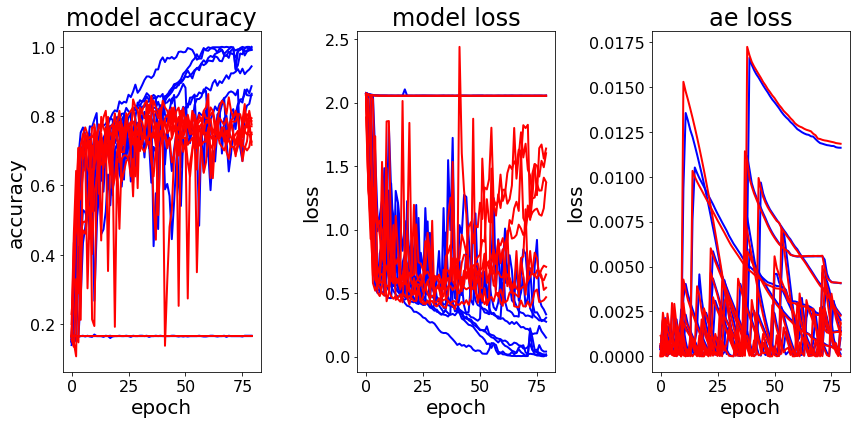

[86.40776872634888, 82.52426981925964, 83.33333134651184, 16.66666716337204, 78.78788113594055, 85.85858345031738, 82.47422575950623, 81.25, 16.66666716337204, 78.94737124443054]
69.29167658090591


In [27]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(np.vstack([_['accuracy'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_accuracy'] for _ in hists]).T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(np.vstack([_['loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_loss'] for _ in hists]).T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(np.vstack([_['ae_loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_ae_loss'] for _ in hists]).T, 'r')
plt.title('ae loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

print([100*max(_['val_accuracy']) for _ in hists])
print(100 * np.mean([max(_['val_accuracy']) for _ in hists]))

Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 74% and 85%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [28]:
# Load the 'best' model from disk.
tf.keras.backend.clear_session()
from tensorflow.keras.models import load_model
model = load_model(datadir / 'models' / (SESS_ID + '_model_best_all.h5'))
# model.summary()

199


W1003 10:25:24.126516  9904 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.


### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw spiketrains do not decompose to very well so for inputs we will use spikerates that are previously derived from the spike trains convolved with a gaussian kernel (sigma=50 msec).

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
tbs = 30  # tsne batch size

TEST_PERPLEXITY = 20  # 10, 30

def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Ppx: {})'.format(perplexity))
    ax = plt.gca()

41152


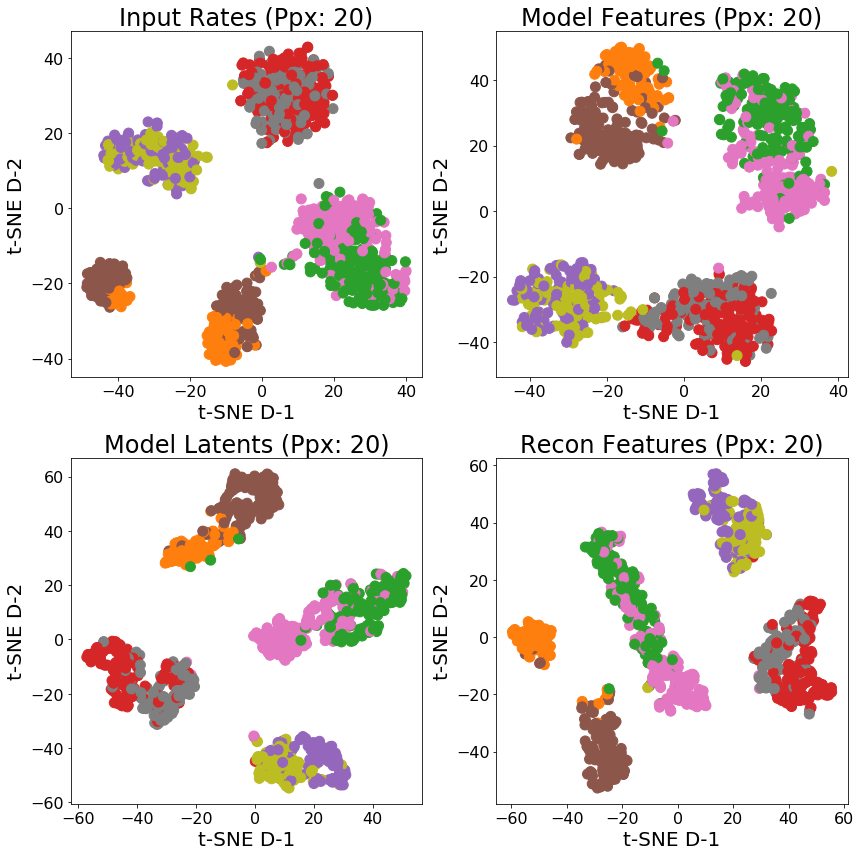

In [39]:
fig = plt.figure(figsize=(12, 12))

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(rates_X.reshape([-1, np.prod(rates_X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 1)
plot_tsne(tsne_values, rates_Y.ravel()+1, TEST_PERPLEXITY, title='Input Rates')

# Let's create a version of our CNN model that goes from input to the bottleneck layer
truncated_model = tf.keras.Model(model.input, [model.layers[7].output,
                                               model.get_layer('latent').output,
                                               model.layers[-6].output])
rates = []
latents = []
recon_rates = []
for start_ix in range(0, X.shape[0], tbs):
    temp = X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]
    _rates, _latents, _recon_rates = truncated_model(temp)
    rates.append(_rates)
    latents.append(_latents)
    recon_rates.append(_recon_rates)
    
rates = tf.concat(rates, 0).numpy()
latents = tf.concat(latents, 0).numpy()
recon_rates = tf.concat(recon_rates, 0).numpy()
tf.keras.backend.clear_session()

flattened_rates = rates.reshape([-1, np.prod(rates.shape[1:])])
flattened_latents = latents.reshape([-1, np.prod(latents.shape[1:])])
flattened_recon_rates = recon_rates.reshape([-1, np.prod(recon_rates.shape[1:])])

# Model Rates
pca = PCA(n_components=50)
pca_values = pca.fit_transform(flattened_rates)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 2)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Features')

# Model Latents
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_latents)
plt.subplot(2, 2, 3)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Latents')

# Recon Rates
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_recon_rates)
plt.subplot(2, 2, 4)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Recon Features')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

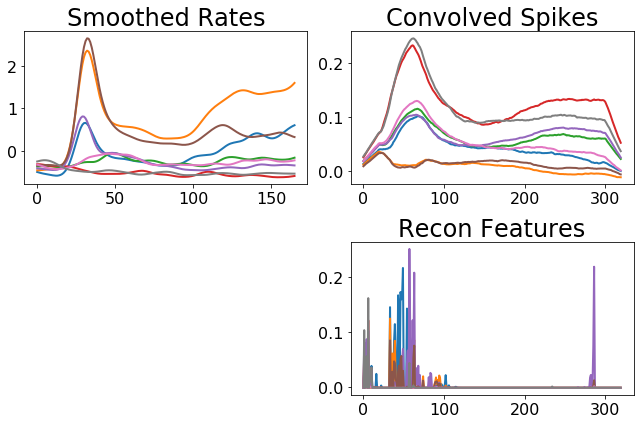

In [93]:
fig = plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
chan_ix = 31  # 4
_X = rates_X
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Smoothed Rates')

plt.subplot(2, 2, 2)
chan_ix = -4  # 4
_X = rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Convolved Spikes')

plt.subplot(2, 2, 4)
chan_ix = -4  # 4
_X = recon_rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Recon Features')

plt.tight_layout()

fig.savefig(str(datadir / (SESS_ID + '_example_rates.png')))

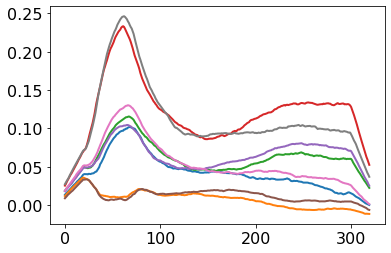

CP_ALS: iteration 1, objective 0.9943709492364587, improvement inf.
CP_ALS: iteration 2, objective 0.9585180588008998, improvement 0.03585289043555895.
CP_ALS: iteration 3, objective 0.9303627278158269, improvement 0.028155330985072946.
CP_ALS: iteration 4, objective 0.919844315212275, improvement 0.010518412603551797.
CP_ALS: iteration 5, objective 0.9173296819100868, improvement 0.0025146333021882628.
CP_ALS: iteration 6, objective 0.9168322133151304, improvement 0.0004974685949563629.
CP_ALS: iteration 7, objective 0.9167128826306711, improvement 0.00011933068445935113.
CP_ALS: iteration 8, objective 0.9166803468063847, improvement 3.25358242864171e-05.
CP_ALS: iteration 9, objective 0.9166694312160174, improvement 1.0915590367255312e-05.
CP_ALS: iteration 10, objective 0.9166643025653406, improvement 5.1286506768111195e-06.
Converged after 10 iterations, 0.8366571000000249 seconds. Objective: 0.9166643025653406.


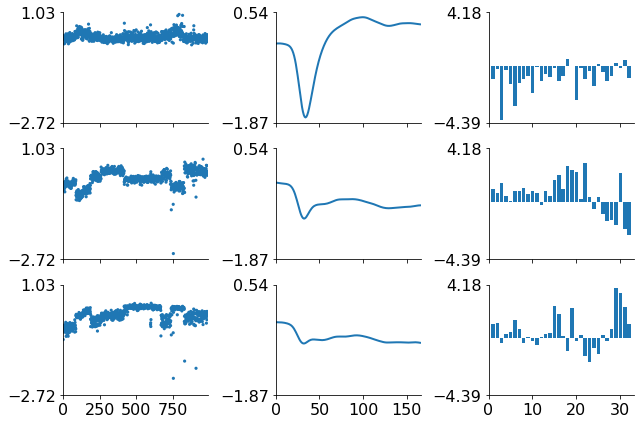

In [49]:
import tensortools as tt

U = tt.cp_als(np.squeeze(rates_X), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

CP_ALS: iteration 1, objective 0.41718433231435426, improvement inf.
CP_ALS: iteration 2, objective 0.31490285735246376, improvement 0.1022814749618905.
CP_ALS: iteration 3, objective 0.31361586161755944, improvement 0.001286995734904317.
CP_ALS: iteration 4, objective 0.3121421632664631, improvement 0.001473698351096342.
CP_ALS: iteration 5, objective 0.3104050946298907, improvement 0.0017370686365724142.
CP_ALS: iteration 6, objective 0.3084441265404375, improvement 0.0019609680894531745.
CP_ALS: iteration 7, objective 0.3063440307371451, improvement 0.002100095803292401.
CP_ALS: iteration 8, objective 0.30421648380747324, improvement 0.002127546929671875.
CP_ALS: iteration 9, objective 0.3021663714825465, improvement 0.002050112324926745.
CP_ALS: iteration 10, objective 0.30026422051895546, improvement 0.0019021509635910316.
CP_ALS: iteration 11, objective 0.29853989810557846, improvement 0.0017243224133769997.
CP_ALS: iteration 12, objective 0.2969932033321372, improvement 0.001546

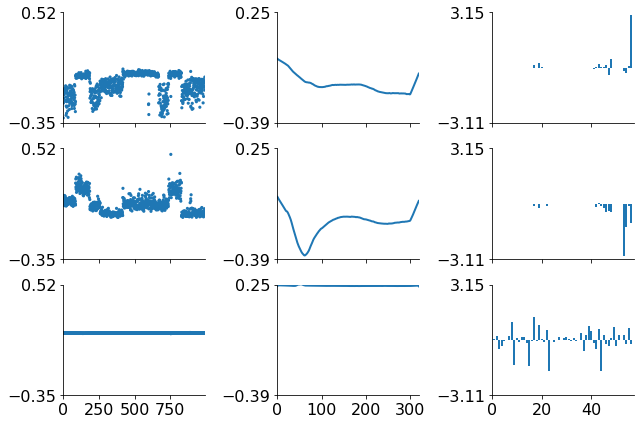

In [51]:
U = tt.cp_als(np.squeeze(rates), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

### First convolutional layers
The first pair of convolutional layers are simply performing time-domain convolutions on the spike trains.
Whereas a typically signal processing pipeline will apply a gaussian, exponentional, or gamma kernel convolution,
here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

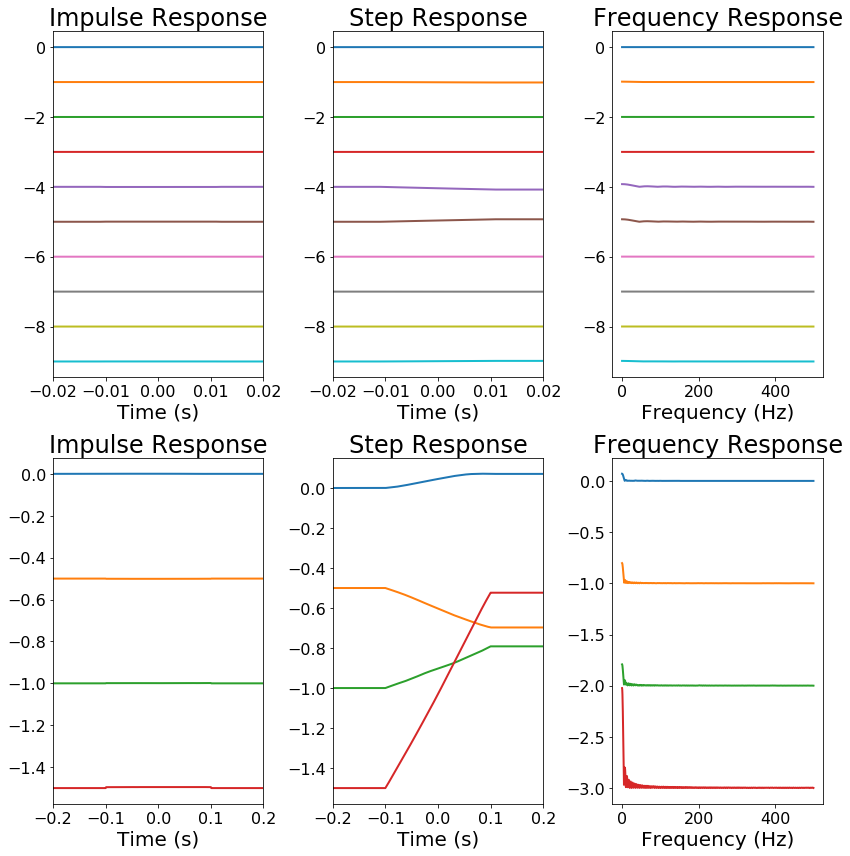

In [36]:
import scipy.signal

fig = plt.figure(figsize=(12, 12))
t = ax_info['timestamps']

x_ranges = [[-0.02, 0.02], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

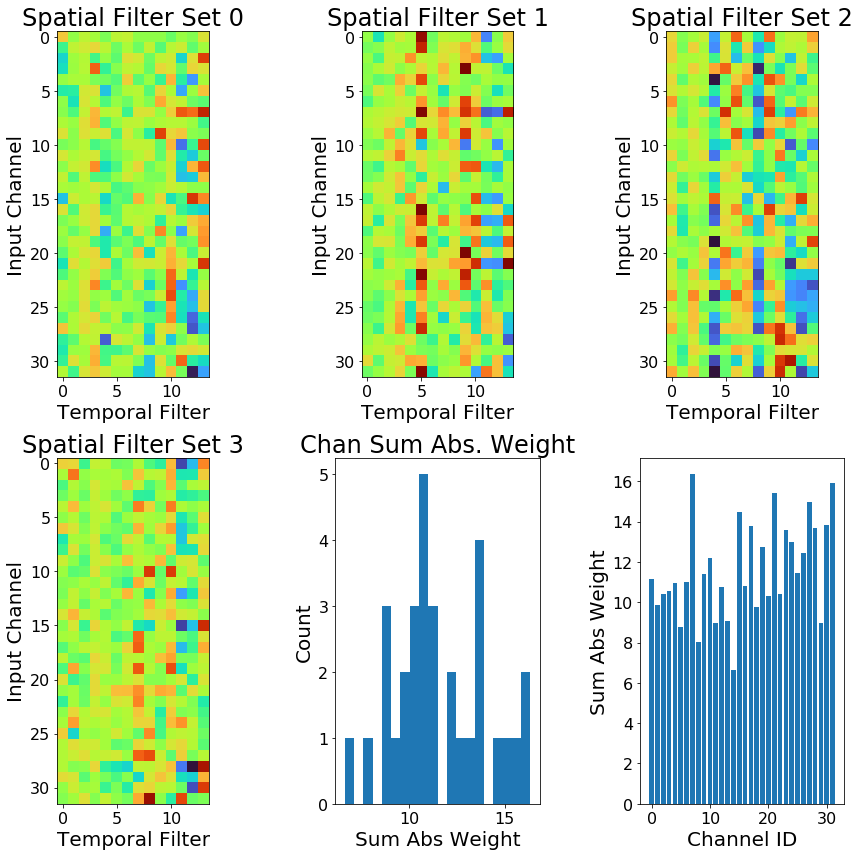

In [37]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12))
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_SpatFilts.png')))

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Filter Activation-Maximizing Inputs

One useful way to understand what a convolutional layer is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer.

Remembering back to the step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [76]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

In [ ]:
# 4 is DepthwiseConv2D, 9 is SeparableConv2D
plot_layer(9, max_filts=9)

### Class Maximizing Inputs
If we extend our reasoning from filter activations down to the next-to-last layer (15), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (16), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

In [ ]:
plot_layer(15, n_steps=100)

## Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
def get_losses_for_class(test_class):
    classes, y = np.unique(Y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id, MAX_OFFSET:, :].astype(np.float32)[None, :, :, None])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        losses_grads.append((loss_value, grads))
    return losses_grads

In [ ]:
# Plot saliency image for a few trials in a particular class
N_SALIENCY_TRIALS = 3
TEST_CLASS = 5  # -1 to 6
losses_grads = get_losses_for_class(TEST_CLASS)
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
re_ix = np.argsort(loss_vals)
b_class = np.squeeze(Y == TEST_CLASS)
_x = X[b_class, MAX_OFFSET:][re_ix][:N_SALIENCY_TRIALS]
_masks = grad_vals[re_ix][:N_SALIENCY_TRIALS]

fig = plt.figure(figsize=(8, 6), facecolor='white')
for tr_ix in range(N_SALIENCY_TRIALS):
    plt.subplot(N_SALIENCY_TRIALS, 1, tr_ix + 1)
    plt.imshow(_masks[tr_ix].T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    plt.eventplot([np.where(_)[0] for _ in _x[tr_ix].T], colors='k')
    for _t in t0_ix:
        plt.axvline(_t)
plt.xlabel('Sample')
plt.ylabel('Channel ID')
plt.tight_layout()

In [ ]:
# Plot average saliencies for all trials within each class
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

fig = plt.figure(figsize=(12, 18), facecolor='white')

for ix, class_id in enumerate(np.unique(Y)):
    losses_grads = get_losses_for_class(class_id)
    loss_vals = [_[0][0].numpy() for _ in losses_grads]
    grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
    grad_vals = np.mean(grad_vals, axis=0)
    plot_ix = 2 * ix + 1 * (ix < 4) - 6 * (ix >= 4)
    plt.subplot(4, 2, plot_ix)
    plt.imshow(grad_vals.T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    for _t in t0_ix:
        plt.axvline(_t)
    plt.title(str(class_id))
    if (ix + 1) % 4 == 0:
        plt.xlabel('Sample')
    if ix < 4:
        plt.ylabel('Channel')
plt.tight_layout()

## Class Activation Maps

Class activation maps (CAM) highlight the parts of the input that contribute most to each classification score. This is similar but different to saliency mapping. Whereas in saliency mapping the losses are back-propagated all the way back to the inputs, in CAM (or [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)) the per-class scores / losses are propaged backward only to the last convolutional layer. These losses are then used as the weights in a weighted average of the feature map output of the last convolutional layer. If the result is smaller than the input, it is then interpolated to match the input size.

Remember that in image classification the data have width pixels x height pixels x colour depths, but in our neural time-series data we have time samples x 1 x electrodes. We could use CAM on our timeseries data to identify which time points are important for each class but not channels because CAM averages across 'depth'. Time-point importance is unlikely to be informative in this dataset because it is unlikely that the timing of processing visual cues and creating motor plans is class-dependent, especially not at the time scales of the final convolution output (~100 msec).

To get any information about which channels of the input were important, we would have to project the losses back to before the spatial filter layer (`DepthwiseConv2D`).

TODO: Cluster channels based on cross-correlations of per-trial saliency maps.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    k_spike_short = params.get('k_spike_short', 10)
    l_spike_short = params.get('l_spike_short', 22)
    k_spike_long = params.get('k_spike_long', 4)
    l_spike_long = params.get('l_spike_long', 200)
    D = params.get('D', 4)
    downsamp_1 = params.get('downsamp_1', 5)
    n_pointwise_filters = params.get('n_pointwise_filters', 38)
    kern_length_2 = params.get('kern_length_2', 40)
    downsamp_2 = params.get('downsamp_2', 8)
    norm_rate = params.get('norm_rate', 0.3)
    dropout_rate = params.get('dropout_rate', 0.3)
    latent_dim = params.get('latent_dim', 10)
    gamma = params.get('gamma', 1.0)
    window_scale = params.get('window_scale', 1.0)
    l1_reg = params.get('l1_reg', 0.0002)
    l2_reg = params.get('l2_reg', 0.0002)
    epochs = params.get('epochs', 80)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=123)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    tf.keras.backend.clear_session()
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       k_spike_short=k_spike_short, l_spike_short=l_spike_short,
                       k_spike_long=k_spike_long, l_spike_long=l_spike_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    max_val_acc = max(history.history['val_accuracy'])
    print("Max validation accuracy with these parameters: {}".format(max_val_acc))
    
    tf.keras.backend.clear_session()
    
    return -max_val_acc

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest

space = {
#     'k_spike_short': scope.int(hp.quniform('k_spike_short', 1, 15, 1)),
#     'l_spike_short': scope.int(hp.quniform('l_spike_short', 8, 50, 2)),
    'k_spike_long': scope.int(hp.quniform('k_spike_long', 1, 15, 1)),
#     'l_spike_long': scope.int(hp.quniform('l_spike_long', 60, 250, 5)),
#     'D': scope.int(hp.quniform('D', 1, 12, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 4, 10, 1)),
#     'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 64, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 9, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     '12_reg': hp.loguniform('l1_reg', np.log(0.000001), np.log(1.0)),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(1.0)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
    'latent_dim': scope.int(hp.quniform('latent_dim', 5, 50, 5)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(100)),
    'window_scale': hp.loguniform('window_scale', np.log(1e-4), np.log(100))
}    

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 5.
minutes_per_eval = 2.5
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
print("Best Acc: {}".format(-trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

In [ ]:
def scatterplot_matrix_colored(params_names, params_values, best_losses,
                               alpha=0.3, minmax='min'):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    
    best_losses = np.array(best_losses)
    if minmax == 'min':
        best_trial = np.argmin(best_losses)
    else:
        best_trial = np.argmax(best_losses)
        
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
            axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=alpha,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored according to best validation loss')
    plt.show()

# Prepare loss values. Maybe transform.
hp_loss = np.array([_['result']['loss'] for _ in trials.trials])
hp_loss = -hp_loss

hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
log_hps = [_ for _ in ['l1_reg', 'l2_reg', 'window_scale', 'gamma'] if _ in hp_names]
for hp_name in log_hps:
    hp_vals[hp_names.index(hp_name)] = np.log10(hp_vals[hp_names.index(hp_name)])

scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, minmax='max',
                           alpha=0.8)
print(np.max(hp_loss))

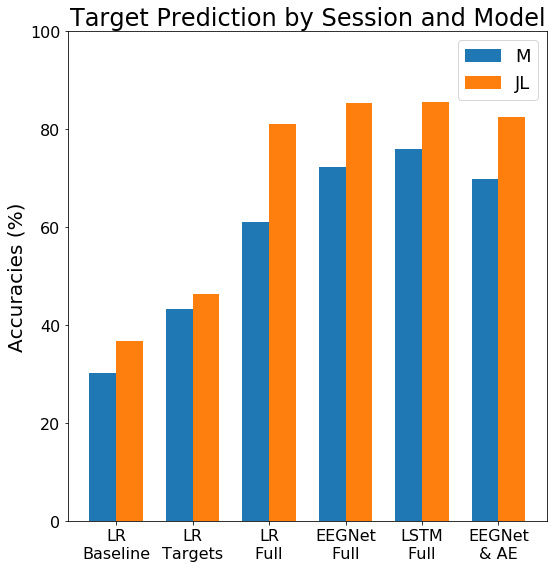

In [18]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull', 'EEGNet\n& AE']
accuracies = [[30.2, 43.4, 61.2, 72.3, 76.1, 69.9],[36.8, 46.5, 81.1, 85.4, 85.5, 82.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()
plt.tight_layout()

fig.savefig(str(datadir / ('Acc_Bars.png')))